In [1]:
from rule_generation import * 

### Carregando a base de dados de interesse

Mude a base de dados de acordo com o nome sorteado.

In [2]:
df_name = 's_temp_ubatuba.csv'
df = pd.read_csv(df_name)
df.drop(columns='time', inplace=True)

Transformando a série temporal em uma base de dados com lags.

In [3]:
max_lagged = 12

df = df[['value']].copy()
df.columns = ['target']
for i in range(1, max_lagged):
    df[f'lag_{i}'] = df['target'].shift(i)
df.dropna(inplace=True)

df = df.iloc[:, ::-1]

### Criando a variável linguística para cada um dos lags do problema. 

Nessa etapa, crie e modifique as variáveis linguísticas (e seus respectivos conjuntos Fuzzy) para chegar a uma melhor resposta. 

Abaixo tem uma ideia de como criar essa lista de variáveis linguísticas de uma forma enxuta e rápida. Contudo, tente você também fazer suas adaptações.

In [4]:
min_value = min(df.min())
max_value = max(df.max())

num_fuzzy_sets = 7

variable_list = [ctrl.Antecedent(np.arange(min_value - 1, max_value + 1, 1), name) if name != 'target' else ctrl.Consequent(np.arange(min_value - 1, max_value + 1, 1), name) for name in df.columns]
for variable in variable_list:
    variable.automf(num_fuzzy_sets)

### Divisão da base de dados (treino e teste)

In [26]:
# Split between train and test dataframes
train_df = df.iloc[:int(len(df) * 0.9)]
test_df = df.iloc[int(len(df) * 0.9):]

### Criando o sistema Fuzzy usando o método Wang-Mendel

In [27]:
fuzzy_system = create_fuzzy_system(train_df, variable_list, 1)


### Fazendo a previsão para o conjunto de treino e de teste.

In [28]:
def predict(df):
    df_copy = df.copy()
    df_copy.loc[:, 'predict'] = np.nan
    # Create a loop to predict the values 
    for i in range(len(df_copy)):
        l = df_copy.iloc[i,:].shape[0] - 2
        for k in range(l):
            fuzzy_sim.input[f'lag_{l - k}'] = df_copy.iloc[i, k]
        try:
            fuzzy_sim.compute()
            out = fuzzy_sim.output['target']
        except:
            out = df_copy.iloc[i, k]
        df_copy.iloc[i, l + 1] = out 
    return df_copy 

In [29]:
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_system)

predict_train_df = predict(train_df)

In [30]:
predict_test_df = predict(test_df)

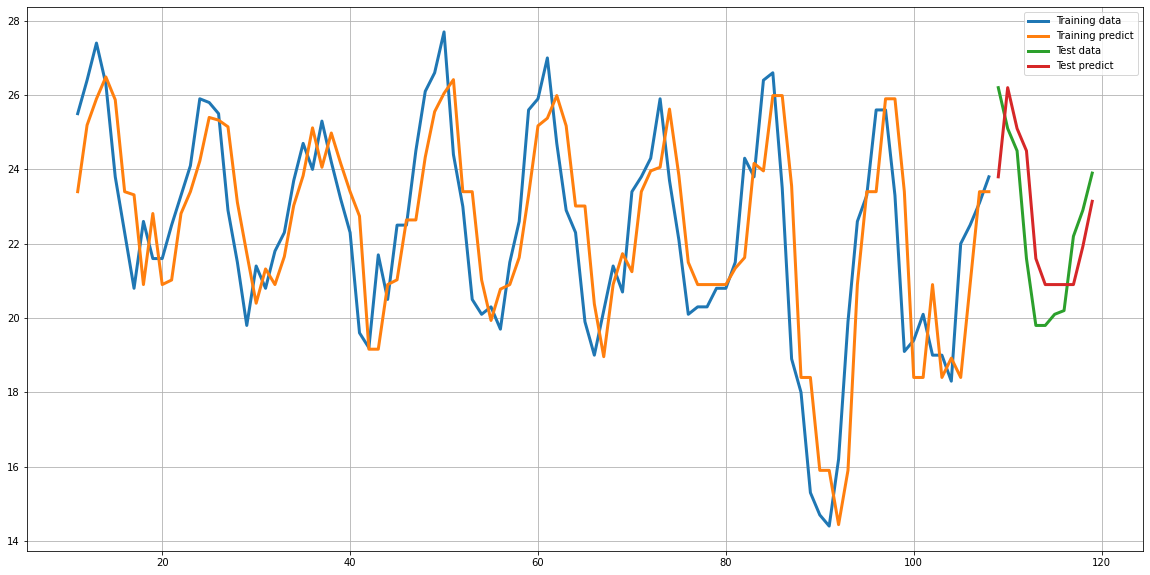

In [33]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20, 10))
plt.plot(predict_train_df['target'], label='Training data', linewidth=3)
plt.plot(predict_train_df['predict'], label='Training predict', linewidth=3)
plt.plot(predict_test_df['target'], label='Test data', linewidth=3)
plt.plot(predict_test_df['predict'], label='Test predict', linewidth=3)
plt.legend()
plt.grid()

plt.show()